# MSA 2024 Phase 2 - Part 2

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## 1. Load and split preprocessed data

In [76]:
#the data is scaled already
monthly_red_cols= pd.read_csv("monthly_red_cols.csv", encoding='latin1',delimiter=',',header='infer')
monthly_red_cols['Order Date'] = pd.to_datetime(monthly_red_cols['Order Date'])

# Set 'Order Date' as the index
monthly_red_cols.set_index('Order Date', inplace=True)



In [77]:
monthly_red_cols.index.freq

## 2. Choose an algorithm

In [78]:

#checking for autocorrelation to help identify the repeating patterns in the data and help us select the right terms when fitting our time series model
autocorrelation_lag1 = monthly_red_cols['Sales'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = monthly_red_cols['Sales'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = monthly_red_cols['Sales'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag12 = monthly_red_cols['Sales'].autocorr(lag=12)
print("Twelve Month Lag: ", autocorrelation_lag12)


One Month Lag:  0.3113444663406203
Three Month Lag:  0.14771399488747908
Six Month Lag:  0.04762804104570503
Twelve Month Lag:  0.884217856181939


## 3. Train and test a model

In [79]:
monthly_red_cols.head()


,Discount,Sales,Profit,Sub-Category_Bookcases,Sub-Category_Tables,Region_Central,Region_South,State_Alabama,State_Arizona,State_Arkansas,...,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Segment_Home Office,Year
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-01-31,0.201923,6242.525,805.4665,5,1,4,8,0,1,2,...,3,0,0,0,0,5,0,3,3,2014
2014-02-28,0.160000,1839.658,120.6917,0,1,4,1,0,0,0,...,1,0,0,0,0,1,1,2,1,2014
2014-03-31,0.203088,14573.956,-1128.6550,3,8,7,9,0,1,0,...,1,4,0,0,0,4,1,4,8,2014
2014-04-30,0.113095,7944.837,554.3801,1,7,4,5,2,0,0,...,1,1,0,0,0,2,1,4,9,2014
2014-05-31,0.269792,6912.787,-349.8776,2,4,9,1,0,0,0,...,0,1,0,1,0,3,2,5,0,2014


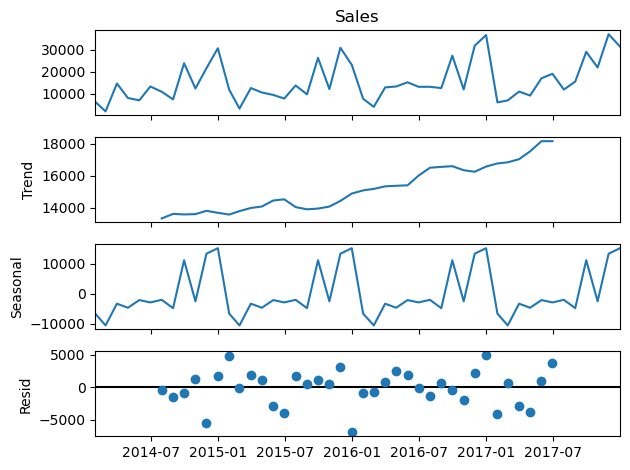

In [6]:
#Dcomposing the data to separate the trend and seasonal components to make it easier to visualize

result = seasonal_decompose(monthly_red_cols['Sales'], model='additive')
# Plot decomposition
result.plot()
plt.show()

From the decomposition plot we can see that here is a strong trend and seasonal pattern. However when we look at the residuals we can see there are some unusual values around December to February each year. For example around February 2015 seems to be a high residual. This could be due to the holiday shopping season or business cycles in retail. From the residuals of this model we can see there's still a pattern remainig, we will aim to capture this pattern by including terms in addition to the seasonal and first order differencing.

In [8]:
#Extract residuals from the decomposition plots to see if there are any unusual values we can visibly see 
residuals = result.resid
# Identify outliers in the residuals that are outside 3 standard deviations 
threshold = 3
outliers = residuals[abs(residuals) > threshold * residuals.std()]
print(outliers)

Series([], Name: resid, dtype: float64)


In [9]:
#checking the stationarity on the residuals to see if trend and seasonal differencing resulted in stationary data

adf_test = adfuller(residuals.dropna())
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -7.603198966899015
p-value: 2.3593438227156728e-11


The residuals are stationary (p-value ≤ 0.05) after applying differencing. This suggests that when fitting our model we would need to apply differencing to ensure that our data meets the time series model assumption that the data must be stationary 

## Plotting each differenced data to visualize the patterns

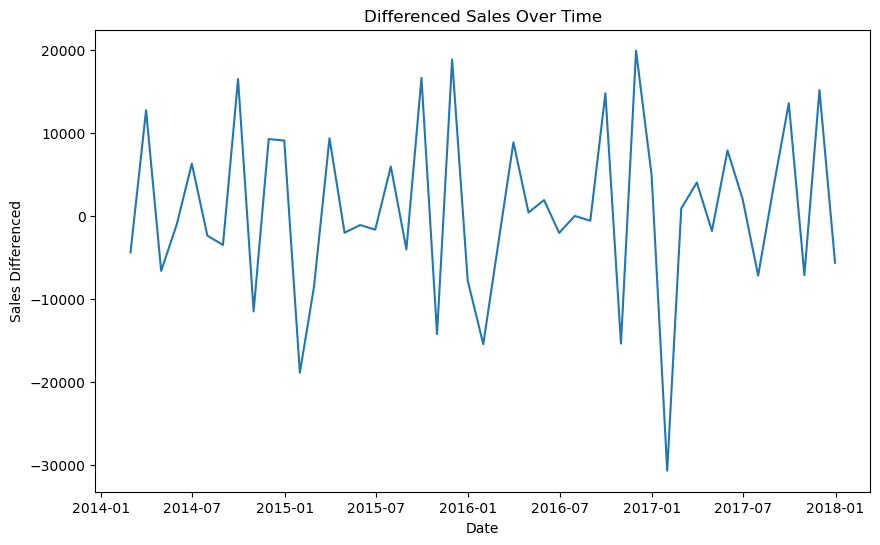

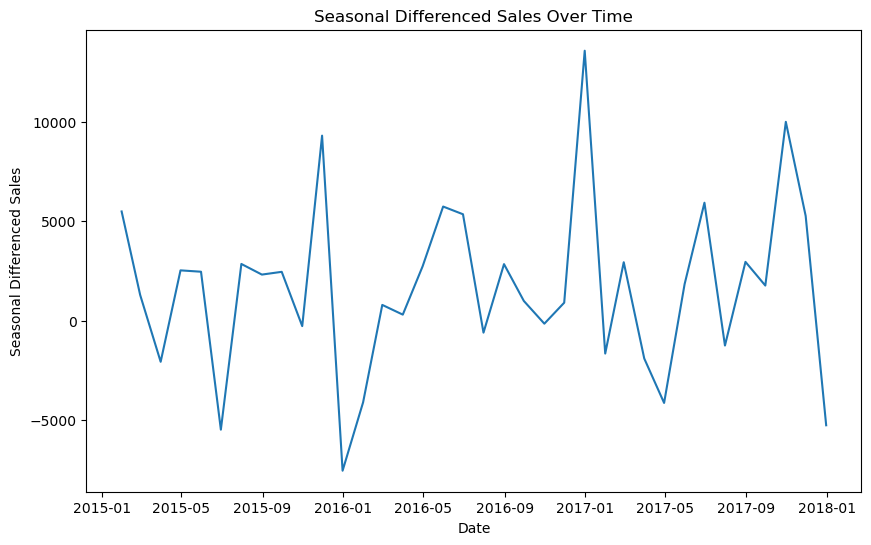

In [80]:
# First-order differencing
data_diff = monthly_red_cols['Sales'].diff().dropna()

# Seasonal differencing
data_seasonal_diff = monthly_red_cols['Sales'].diff(12).dropna()

# Plot differenced data
plt.figure(figsize=(10, 6))
plt.plot(monthly_red_cols.index[1:], data_diff)
plt.xlabel('Date')
plt.ylabel('Sales Differenced')
plt.title('Differenced Sales Over Time')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(monthly_red_cols.index[12:], data_seasonal_diff)
plt.xlabel('Date')
plt.ylabel('Seasonal Differenced Sales')
plt.title('Seasonal Differenced Sales Over Time')
plt.show()

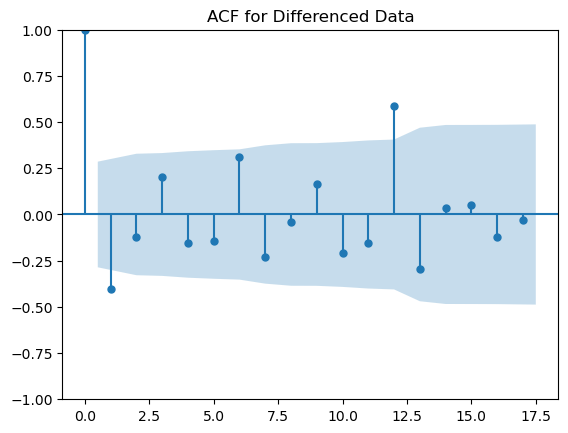

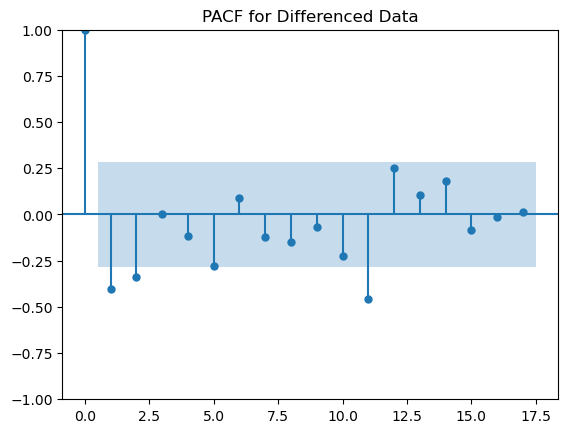

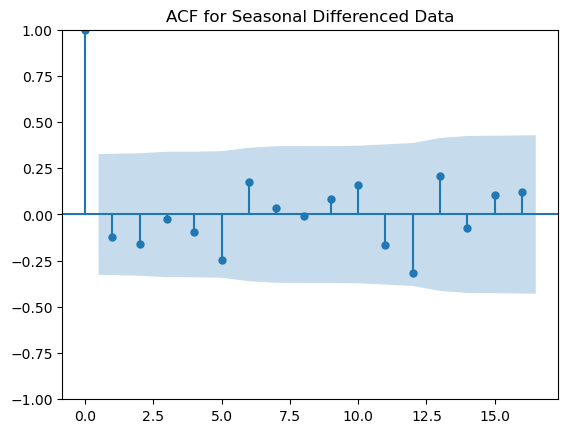

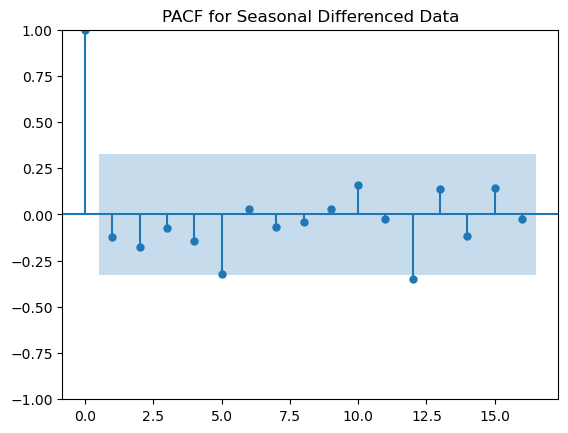

In [81]:

# ACF and PACF plots for differenced data
plot_acf(data_diff)
plt.title('ACF for Differenced Data')
plt.show()

plot_pacf(data_diff)
plt.title('PACF for Differenced Data')
plt.show()

# ACF and PACF plots for seasonal differenced data
plot_acf(data_seasonal_diff)
plt.title('ACF for Seasonal Differenced Data')
plt.show()

plot_pacf(data_seasonal_diff)
plt.title('PACF for Seasonal Differenced Data')
plt.show()

In [82]:
y = monthly_red_cols['Sales']
X = monthly_red_cols.drop(columns=['Sales'])

# Train-test split
train_size = int(len(X) * 0.8)  # 70-30 split
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


After scaling the data it was noted that the p-values became non significant eventhough the lag terms were supposed to be as confirmed on the PACF and ACF plot. Therefore i have decided to use the original unscaled dataset.

C:\Users\filmo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   38
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -251.230
Date:                             Tue, 16 Jul 2024   AIC                            510.461
Time:                                     21:09:48   BIC                            515.336
Sample:                                 01-31-2014   HQIC                           511.813
                                      - 02-28-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4769      0.149      3.200      0.001       0.185       0.769
ma.L1         -0.8792      

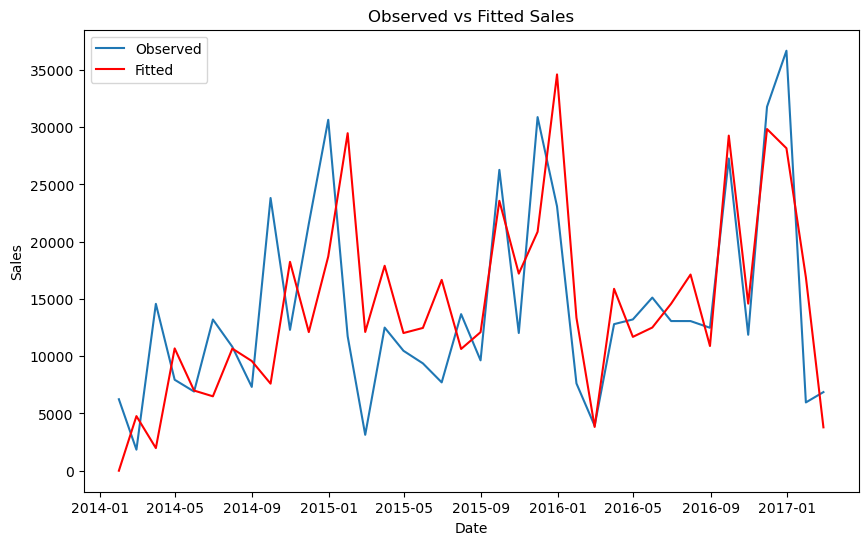

In [83]:

# Set random seed for reproducibility
np.random.seed(42)

# Fit SARIMA model
model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), freq='M')

model_results = model.fit()

# Print model summary
print(model_results.summary())

# Plot the fitted values
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Observed')
plt.plot(model_results.fittedvalues, label='Fitted', color='red')
plt.title('Observed vs Fitted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## 4. Evaluate the model 

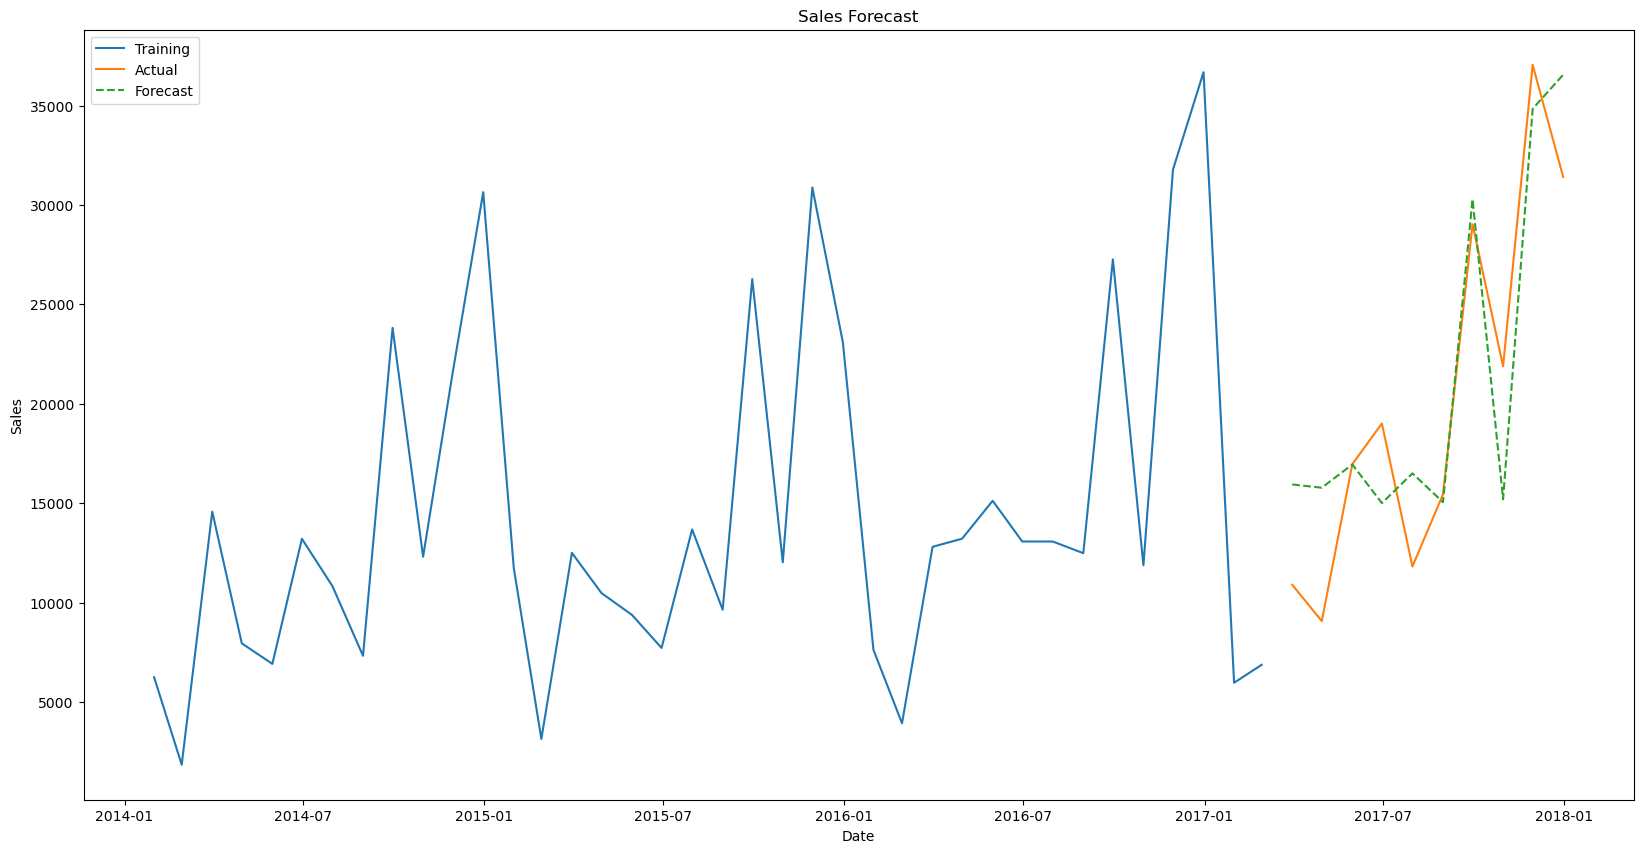

In [84]:

forecasts = model_results.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)

plt.figure(figsize=(20, 10))
plt.plot(y_train, label='Training')
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, forecasts, label='Forecast', linestyle='--')
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [85]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, forecasts)
mse = mean_squared_error(y_test, forecasts)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 3617.304378472471
Mean Squared Error (MSE): 18641729.978832223
Root Mean Squared Error (RMSE): 4317.606973640864


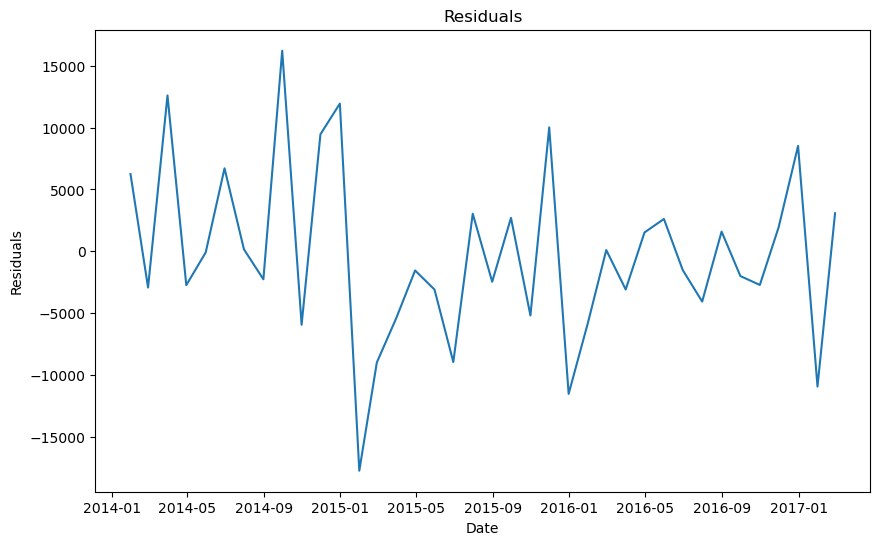

count       38.000000
mean      -275.076975
std       7127.795744
min     -17735.249433
25%      -3821.563828
50%      -1531.201897
75%       2956.153391
max      16212.273379
dtype: float64


In [33]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(model_results.resid)
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Check residuals summary statistics
print(model_results.resid.describe())

In [86]:

adf_test = adfuller(model_results.resid.dropna())
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -7.464485964306229
p-value: 5.248174013729527e-11


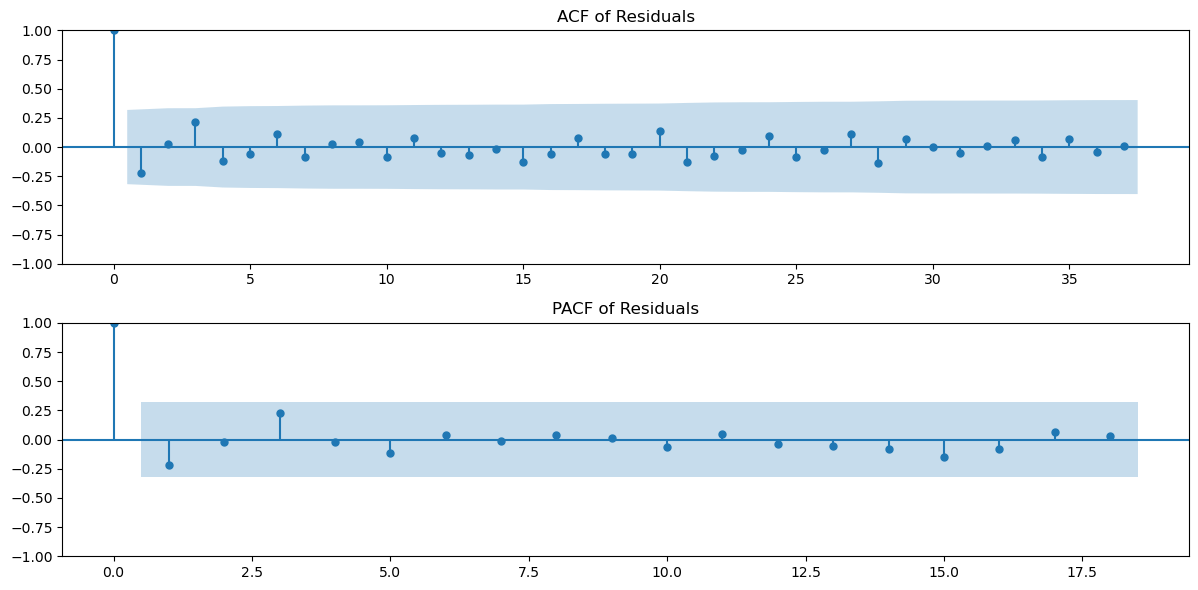

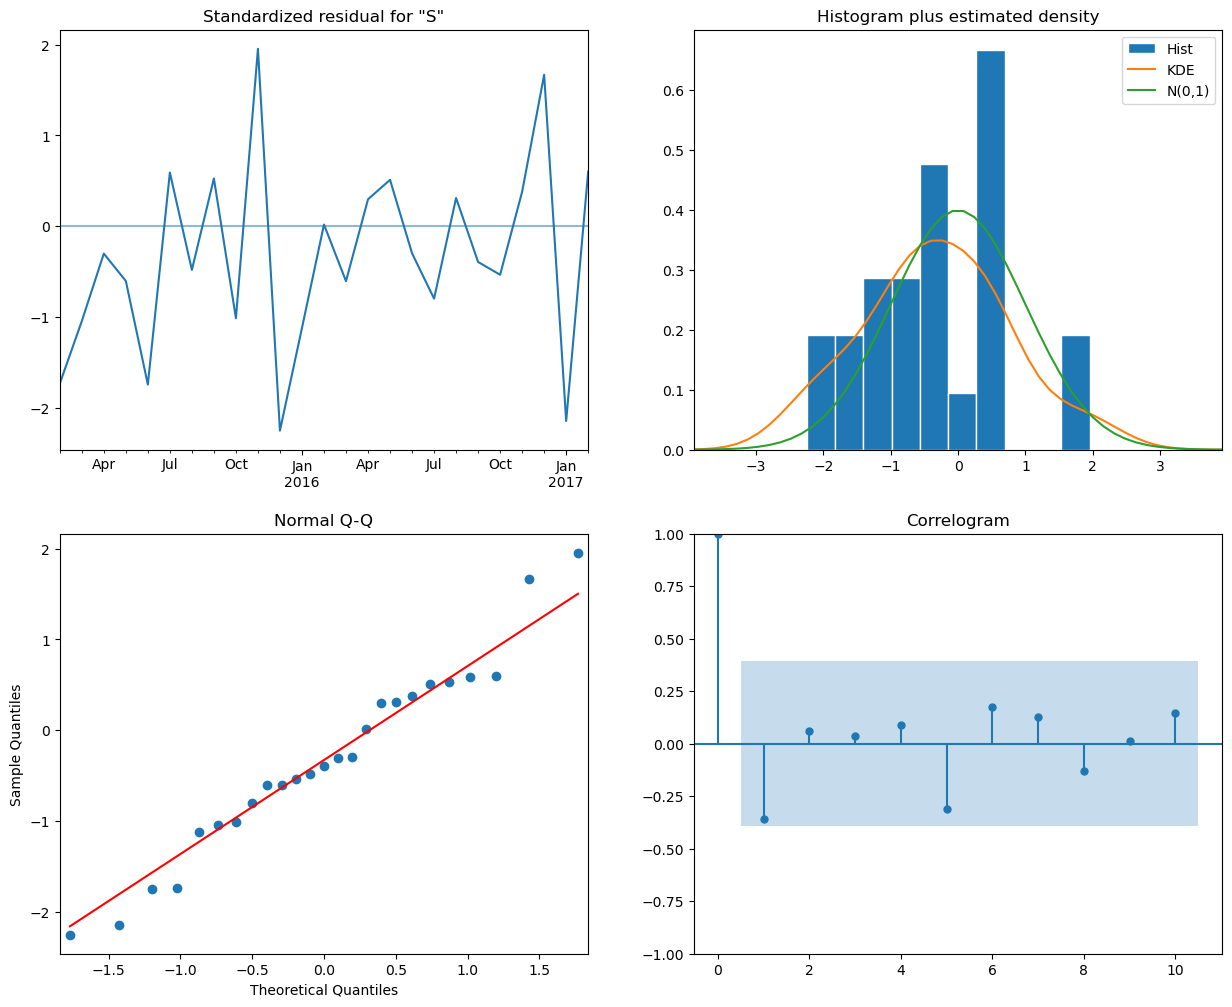

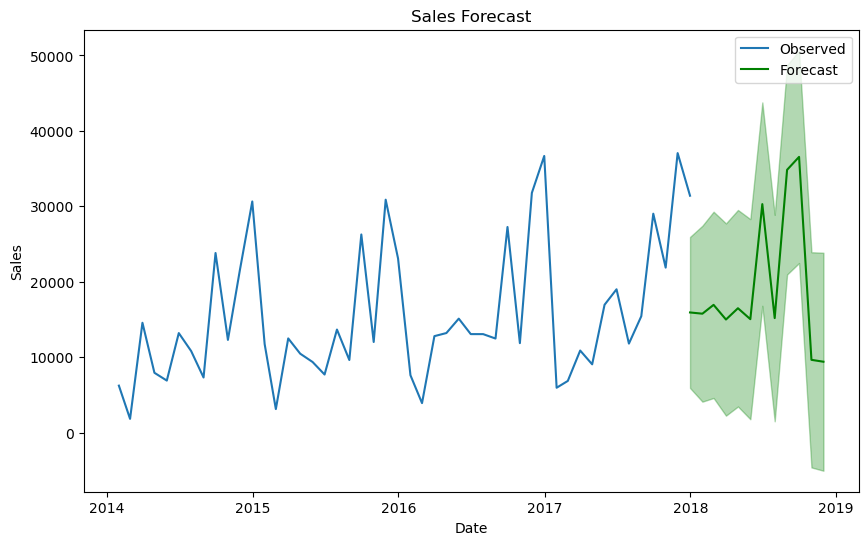

In [91]:
# Extract residuals from the fitted model
residuals = model_results.resid

# Plot ACF of the residuals
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals.dropna(), ax=plt.gca(), lags=37)
plt.title('ACF of Residuals')

# Plot PACF of the residuals
plt.subplot(212)
plot_pacf(residuals.dropna(), ax=plt.gca(), lags=18)
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()

# Diagnostics
model_results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting
forecast = model_results.get_forecast(steps=12)
forecast_index = pd.date_range(start=monthly_red_cols.index[-1], periods=12, freq='M')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(monthly_red_cols['Sales'], label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='green')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Weekly data

In [3]:
weekly_red_cols= pd.read_csv("weekly_reduced_df.csv", encoding='latin1',delimiter=',',header='infer')
weekly_red_cols['Order Date'] = pd.to_datetime(weekly_red_cols['Order Date'])

# Set 'Order Date' as the index
weekly_red_cols.set_index('Order Date', inplace=True)


In [6]:
#checking for autocorrelation to help identify the repeating patterns in the data and help us select the right terms when fitting our time series model
autocorrelation_lag1 = weekly_red_cols['Sales'].autocorr(lag=1)
print("1 week Lag: ", autocorrelation_lag1)

autocorrelation_lag2 = weekly_red_cols['Sales'].autocorr(lag=2)
print("2 week Lag: ", autocorrelation_lag2)

autocorrelation_lag3 = weekly_red_cols['Sales'].autocorr(lag=3)
print("3 week Lag: ", autocorrelation_lag3)

autocorrelation_lag4 = weekly_red_cols['Sales'].autocorr(lag=4)
print("4 week Lag: ", autocorrelation_lag4)

autocorrelation_lag5 = weekly_red_cols['Sales'].autocorr(lag=5)
print("5 week Lag: ", autocorrelation_lag5)

autocorrelation_lag6 = weekly_red_cols['Sales'].autocorr(lag=6)
print("6 week Lag: ", autocorrelation_lag6)

autocorrelation_lag7 = weekly_red_cols['Sales'].autocorr(lag=7)
print("7 week Lag: ", autocorrelation_lag7)
autocorrelation_lag8 = weekly_red_cols['Sales'].autocorr(lag=52)
print("52 week Lag: ", autocorrelation_lag8)


1 week Lag:  0.4051619988496451
2 week Lag:  0.3597972640167129
3 week Lag:  0.2724814318740799
4 week Lag:  0.22777007611698488
5 week Lag:  0.0963984427653425
6 week Lag:  0.118030630337633
7 week Lag:  0.15527264527104095
52 week Lag:  0.5122085115186873


From these lag terms we can see that the weekly data has significant correlation at  1 week and 52 week intervals.

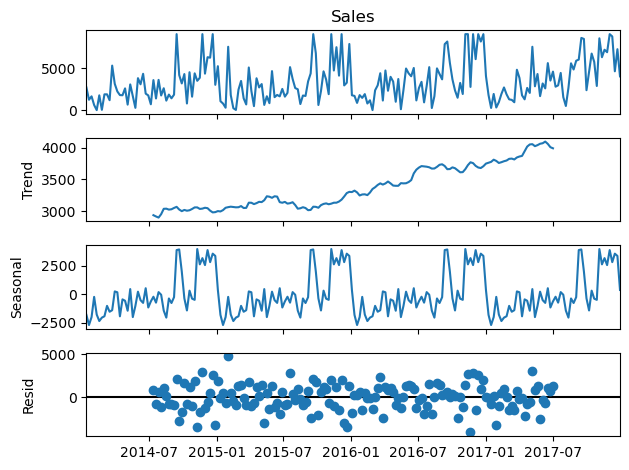

In [9]:
#Dcomposing the data to separate the trend and seasonal components to make it easier to visualize

result = seasonal_decompose(weekly_red_cols['Sales'], model='additive', period = 52)
# Plot decomposition
result.plot()
plt.show()

Look at the decomposition plots there's an increasing trend and annual seasonal pattern present in our dataset. We can see that differencing the trend and seasonal components leads to relatively normally distributed residuals, with constant mean of 0. This is a good indication that we need to include the trend and seasonal differencing parameters in our model to capture the underlying patterns and take are of the autocorrelation.

In [11]:
#Extract residuals from the decomposition plots to see if there are any unusual values we can visibly see 
residuals=result.resid
adf_test = adfuller(residuals.dropna())
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -15.727616087405536
p-value: 1.3010260612558464e-28


The ADF statistic shows a statistically significant p-value which means that the residuals of the decomposition model are stationary. The stationarity assumption is one of the key aspects of the time series models (SARIMA) we intend to use. 

## Visual inspection of differencing 

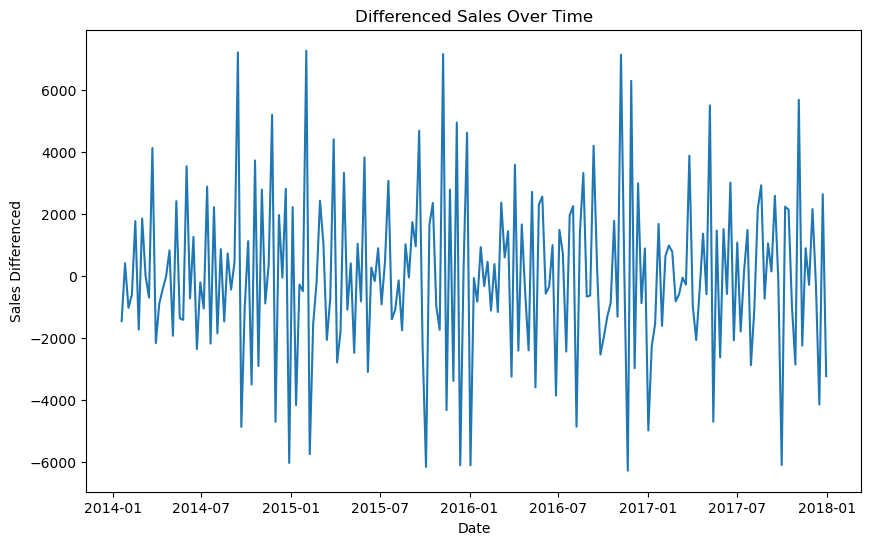

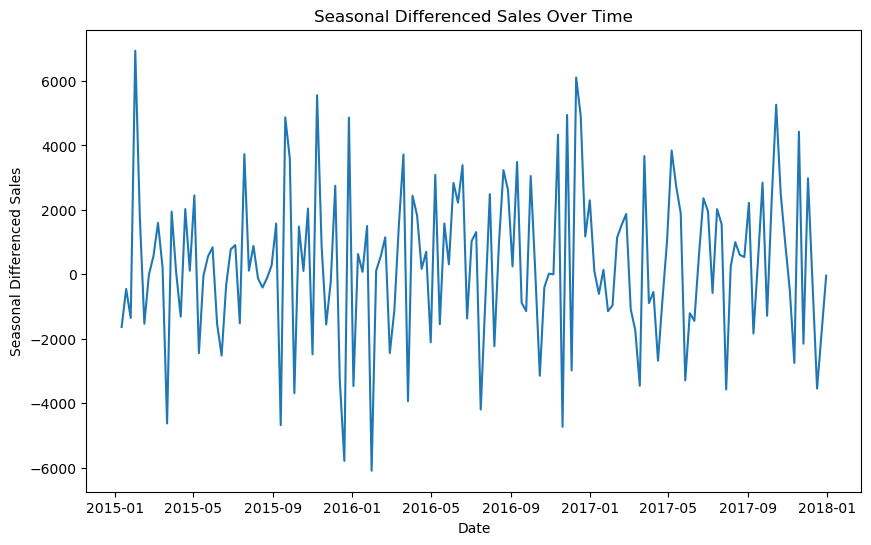

In [13]:
# First-order differencing
data_diff = weekly_red_cols['Sales'].diff().dropna()

# Seasonal differencing
data_seasonal_diff = weekly_red_cols['Sales'].diff(52).dropna()

# Plot differenced data
plt.figure(figsize=(10, 6))
plt.plot(data_diff.index, data_diff)
plt.xlabel('Date')
plt.ylabel('Sales Differenced')
plt.title('Differenced Sales Over Time')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data_seasonal_diff.index, data_seasonal_diff)

plt.xlabel('Date')
plt.ylabel('Seasonal Differenced Sales')
plt.title('Seasonal Differenced Sales Over Time')
plt.show()

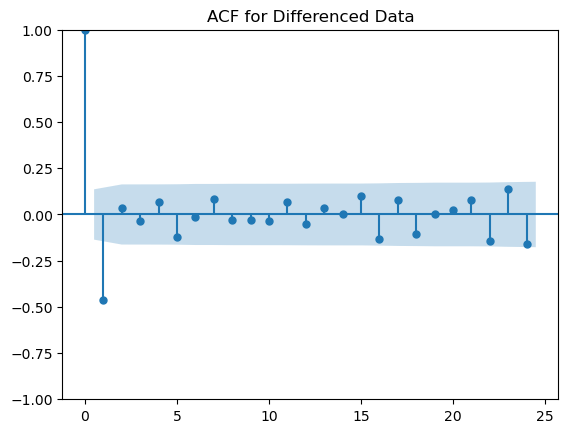

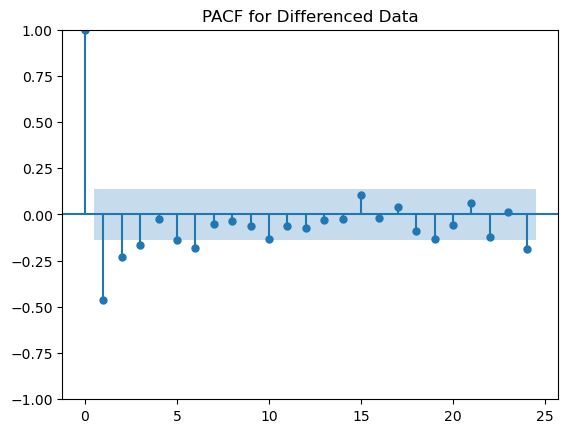

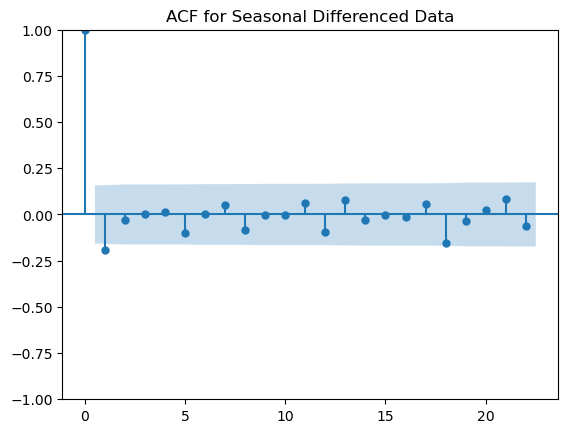

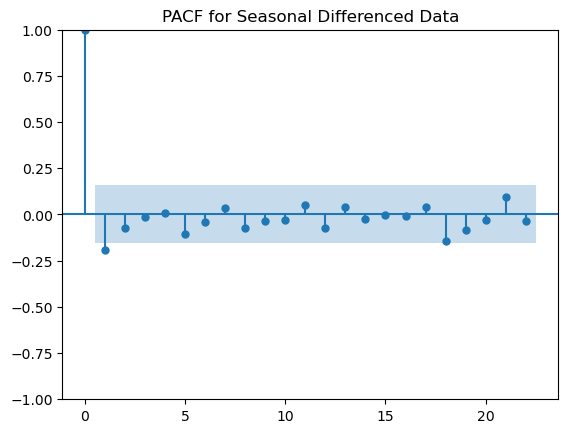

In [14]:

# ACF and PACF plots for differenced data
plot_acf(data_diff)
plt.title('ACF for Differenced Data')
plt.show()

plot_pacf(data_diff)
plt.title('PACF for Differenced Data')
plt.show()

# ACF and PACF plots for seasonal differenced data
plot_acf(data_seasonal_diff)
plt.title('ACF for Seasonal Differenced Data')
plt.show()

plot_pacf(data_seasonal_diff)
plt.title('PACF for Seasonal Differenced Data')
plt.show()

From the ACF and PACF plots we can get an idea of what the AR and MA parameters might be. 

In [16]:
y = weekly_red_cols['Sales']
X = weekly_red_cols.drop(columns=['Sales'])

# Train-test split
train_size = int(len(X) * 0.8)  # 70-30 split
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


C:\Users\filmo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\filmo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\filmo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  166
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1023.024
Date:                            Sat, 20 Jul 2024   AIC                           2056.049
Time:                                    14:39:41   BIC                           2069.686
Sample:                                01-12-2014   HQIC                          2061.582
                                     - 03-12-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2003      0.082     -2.452      0.014      -0.360      -0.040
ma.L1         -1.0000     67.302   

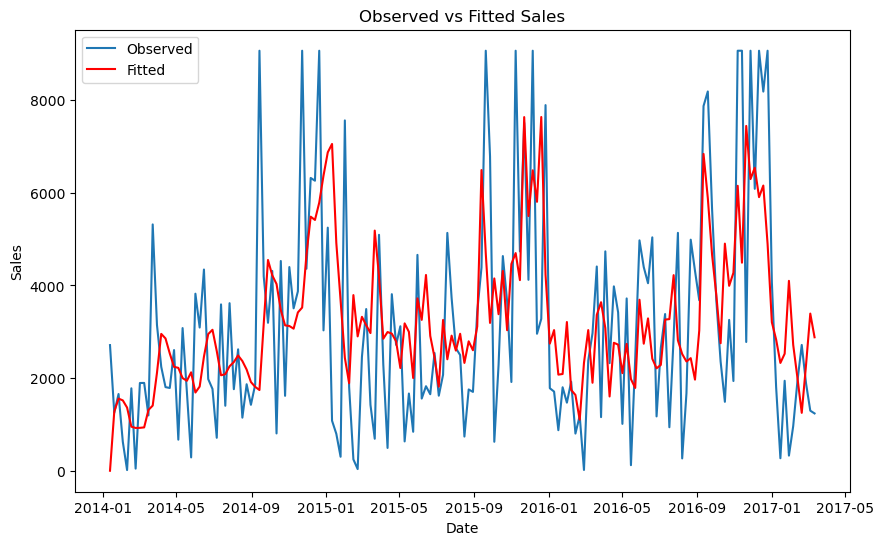

In [25]:

# Set random seed for reproducibility
np.random.seed(42)

# Fit SARIMA model
model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52), freq='W-SUN')

model_results = model.fit()

# Print model summary
print(model_results.summary())

# Plot the fitted values
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Observed')
plt.plot(model_results.fittedvalues, label='Fitted', color='red')
plt.title('Observed vs Fitted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

After trying a few combinations of the parameters such as:
(3, 1, 1)(1, 1, 1, 52) 
(2, 1, 1)(1, 1, 1, 52)
(1, 1, 1)(1, 1, 1, 52) 
We finally arrived at the combination that resulted in significant p-values whilst still capturing the autocorrelation we saw was present in the data from the ACF & PACF plots.

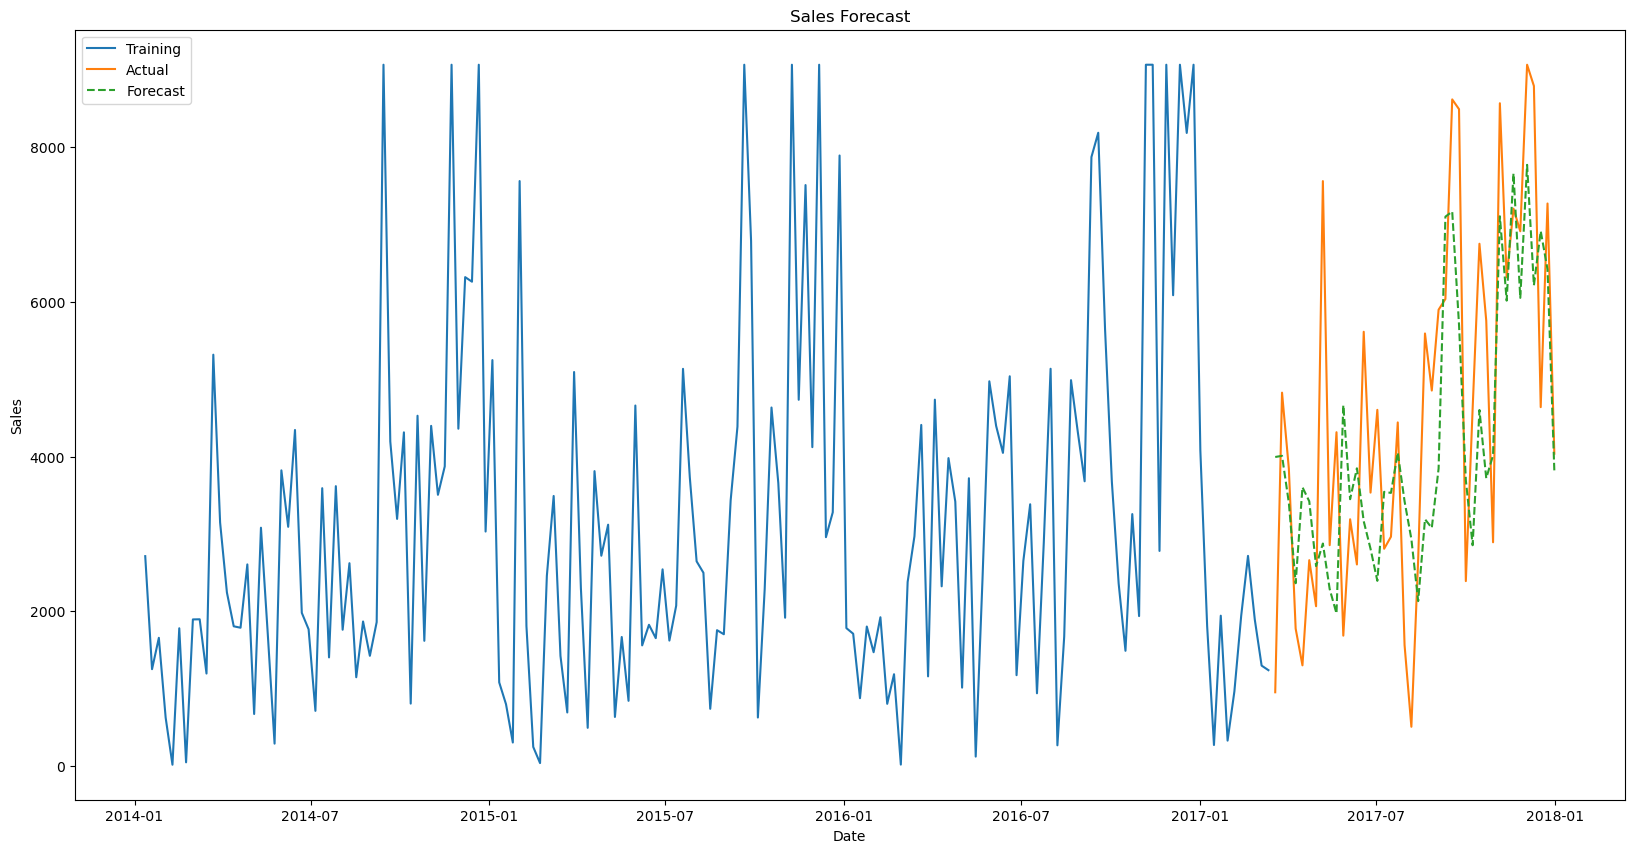

In [26]:
forecasts = model_results.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)

plt.figure(figsize=(20, 10))
plt.plot(y_train, label='Training')
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, forecasts, label='Forecast', linestyle='--')
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [27]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, forecasts)
mse = mean_squared_error(y_test, forecasts)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 1492.6263394052305
Mean Squared Error (MSE): 3178713.5869756513
Root Mean Squared Error (RMSE): 1782.8947212260323


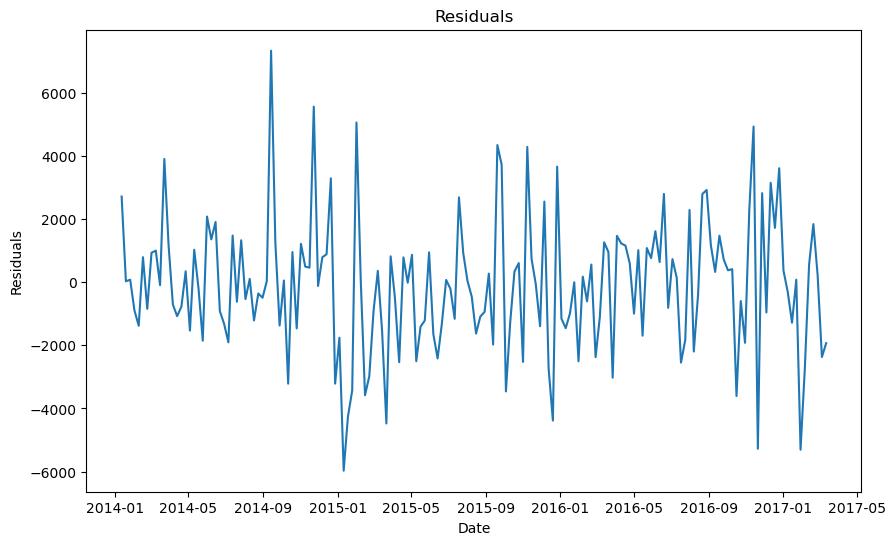

count     166.000000
mean      -96.378533
std      2130.519212
min     -5973.092512
25%     -1379.013097
50%        29.773268
75%       988.141836
max      7331.533963
dtype: float64


In [124]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(model_results.resid)
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Check residuals summary statistics
print(model_results.resid.describe())

In [125]:

adf_test = adfuller(model_results.resid.dropna())
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -12.310072315661785
p-value: 7.124844374190236e-23


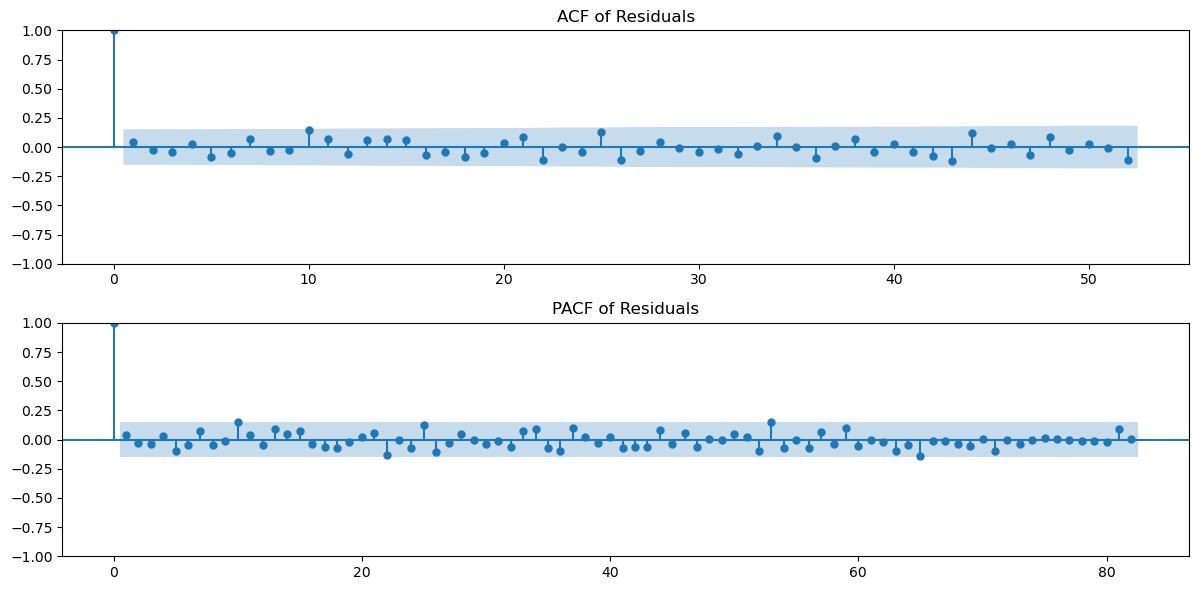

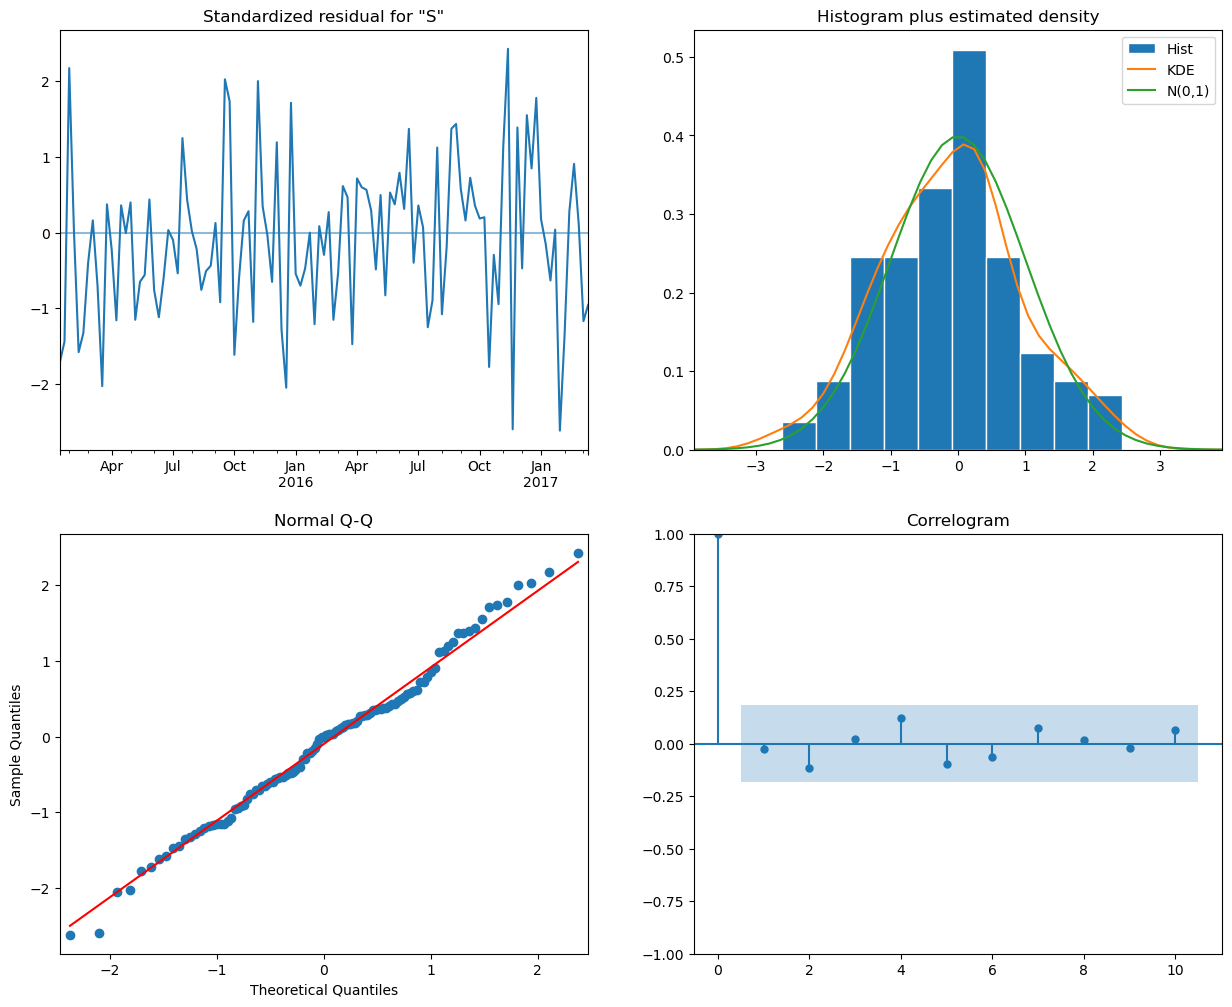

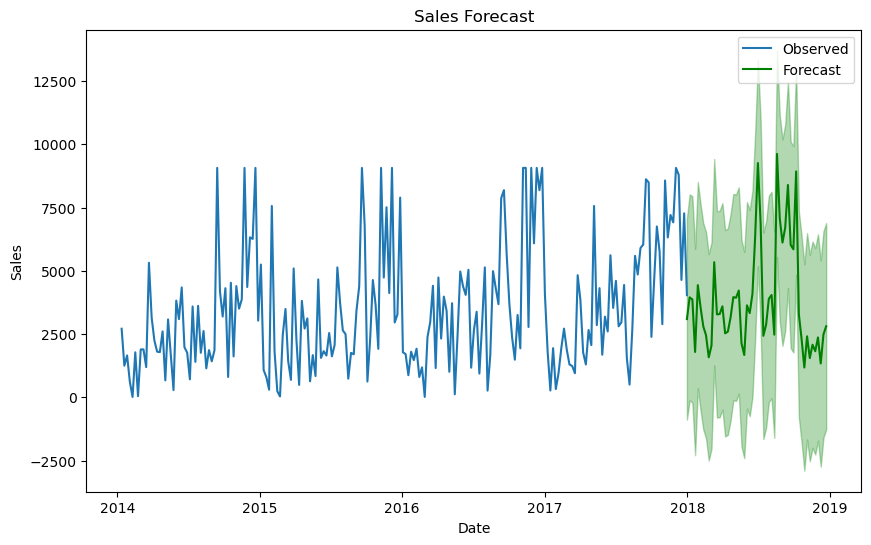

In [129]:
# Extract residuals from the fitted model
residuals = model_results.resid

# Plot ACF of the residuals
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals.dropna(), ax=plt.gca(), lags=52)
plt.title('ACF of Residuals')

# Plot PACF of the residuals
plt.subplot(212)
plot_pacf(residuals.dropna(), ax=plt.gca(), lags=82)
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()

# Diagnostics
model_results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting
forecast = model_results.get_forecast(steps=52)
forecast_index = pd.date_range(start=weekly_red_cols.index[-1], periods=52, freq='W')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(weekly_red_cols['Sales'], label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='green')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## 5. Summary